# Imports

In [1]:
%env CUDA_VISIBLE_DEVICES=0

In [2]:
from comet_ml import Experiment, ExistingExperiment
from comet_ml.integration.pytorch import log_model

In [3]:
import os
import pickle
from tqdm.notebook import tqdm
from copy import deepcopy

from PIL import Image

import numpy as np
import pandas as pd

from sklearn.metrics import f1_score

from torchvision import datasets, transforms

import gc 

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader,Dataset

In [5]:
print(f"Torch: {torch.__version__}")
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)

Torch: 2.0.1+cu117
cuda:0


# Expression Recognition Challenge
## Get target data

In [6]:
idx_to_class_2={0: 'Neutral', 1:'Anger', 2:'Disgust', 3:'Fear', 
                4:'Happiness', 5:'Sadness', 6:'Surprise', 7:'Other'} #ABAW
classes = ['Neutral', 'Anger', 'Disgust', 'Fear', 
           'Happiness', 'Sadness', 'Surprise', 'Other']

In [7]:
IMG_SIZE=224
transform = transforms.Compose(
    [
        transforms.Resize((IMG_SIZE,IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.533, 0.425, 0.374],
                             std=[0.244, 0.214, 0.202])
    ]
)

In [8]:
DATA_DIR = '/home/HDD6TB/datasets/emotions/ABAW/ABAW_6/6th_ABAW_Annotations'
data_dir = '/home/HDD6TB/datasets/emotions/ABAW/ABAW_6/6th_ABAW_Annotations/cropped_aligned/cropped_aligned/'

def get_image2Expr(dirname):
    dirpath=os.path.join(DATA_DIR,'EXPR_Recognition_Challenge/',dirname)
    num_missed=[]
    targets = []
    names = []
    for filename in os.listdir(dirpath):
        fn, ext = os.path.splitext(os.path.basename(filename))
        if ext.lower()=='.txt':
            with open(os.path.join(dirpath,filename)) as f:
                lines = f.read().splitlines()
                prev_val=None
                for i,line in enumerate(lines):
                    if i>0:
                        expression=int(line)
                        if expression>=0:
                            imagename=fn+'/'+str(i).zfill(5)+'.jpg'
                            targets.append(expression)
                            names.append(os.path.join(data_dir, imagename))
    print(len(targets), len(names), len(num_missed))
    return np.array(targets), num_missed, np.array(names)

y_train, num_missed_train, names_train = get_image2Expr('Train_Set')
y_val, num_missed_test, names_val = get_image2Expr('Validation_Set')

597361 597361 0
284230 284230 0


## Get DataLoader

In [9]:
train_idx = np.arange(len(names_train))
val_idx = np.arange(len(names_val))

In [10]:
trainp_loader = DataLoader(train_idx,
                           batch_size=256, 
                           shuffle=True)
valp_loader = DataLoader(val_idx,
                         batch_size=256, 
                         shuffle=False)

In [11]:
def get_images(transform, imgs, y_in):
    img_tensors = []
    y = []
    missed = 0
    for i, img_name in enumerate(imgs):
        try:
            img_name = img_name.replace('\n', '')
            img = Image.open(img_name)
            img_tensor = transform(img)
            if img.size:
                img_tensors.append(img_tensor)
                y.append(y_in[i])

        except:
            try:
                img_name = img_name.replace('cropped_aligned/cropped_aligned', 
                                            'cropped_aligned/cropped_aligned_new_50_vids')
                img = Image.open(img_name)
                img_tensor = transform(img)
                if img.size:
                    img_tensors.append(img_tensor)
                    y.append(y_in[i])
                    
            except:
                missed+=1
            
    try:
        img_tensors = torch.stack(img_tensors)
        y = torch.tensor(y)
            
    except: 
        img_tensors = []
        
    if missed > 0:
        print(f'num of missed frames {missed}')
        
    return img_tensors, y

## Model

In [14]:
counts = np.array([177198, 16573, 10771, 9080, 95463, 78751, 31615, 165866])
unique = np.array([0, 1, 2, 3, 4, 5, 6, 7])
num_classes=len(unique)
cw=1/counts
cw/=cw.min()
class_weights = {i:cwi for i,cwi in zip(unique,cw)}
print(counts, class_weights, num_classes, unique)
print()
print(np.unique(y_val, return_counts=True))

[177198  16573  10771   9080  95463  78751  31615 165866] {0: 1.0, 1: 10.691968865021419, 2: 16.451397270448425, 3: 19.515198237885464, 4: 1.856195594104522, 5: 2.2501047605744686, 6: 5.6048711054879, 7: 1.0683202102902343} 8 [0 1 2 3 4 5 6 7]

(array([0, 1, 2, 3, 4, 5, 6, 7]), array([ 83176,   6127,   5322,   8473,  34941,  25594,  12338, 108259]))


In [15]:
import torch
from torch import nn
import torch.nn.functional as F
from einops import repeat

from mae.encoder import Transformer


class MAE(nn.Module):
    '''
    the implementation from https://github.com/lucidrains/vit-pytorch.
    '''
    def __init__(self,
                 *,
                 encoder,
                 decoder_dim,
                 decoder_depth=1,
                 decoder_heads=8,
                 decoder_dim_head=64,
                 device='cpu'):
        super().__init__()
        # common
        self.device =  device

        # extract some hyperparameters and functions from encoder (vision transformer to be trained)
        self.encoder = encoder
        num_patches, encoder_dim = encoder.pos_embedding.shape[-2:]
        self.patch_to_emb = encoder.patch_to_emb
        pixel_values_per_patch = self.patch_to_emb.weight.shape[-1]

        # decoder parameters
        self.enc_to_dec = nn.Linear(encoder_dim, decoder_dim) if encoder_dim != decoder_dim else nn.Identity()
        self.mask_token = nn.Parameter(torch.randn(decoder_dim))
        self.decoder = Transformer(dim=decoder_dim,
                                   depth=decoder_depth,
                                   heads=decoder_heads,
                                   dim_head=decoder_dim_head,
                                   mlp_dim=decoder_dim * 4)
        self.decoder_pos_emb = nn.Embedding(num_patches, decoder_dim)
        self.to_pixels = nn.Linear(decoder_dim, pixel_values_per_patch)

    def forward(self, img):
        batch, num_masked, masked_indices, masked_patches, encoded_tokens = self.encoder(img)

        # project encoder to decoder dimensions, if they are not equal - the paper says you can get away with a smaller dimension for decoder
        decoder_tokens = self.enc_to_dec(encoded_tokens)

        # repeat mask tokens for number of masked, and add the positions using the masked indices derived above
        mask_tokens = repeat(self.mask_token, 'd -> b n d', b=batch, n=num_masked)
        mask_tokens = mask_tokens + self.decoder_pos_emb(masked_indices)

        # concat the masked tokens to the decoder tokens and attend with decoder
        decoder_tokens = torch.cat((mask_tokens, decoder_tokens), dim=1)
        decoded_tokens = self.decoder(decoder_tokens)
        
        return decoded_tokens

In [16]:
mae_encoder = torch.load('best_local_encoder+partdec.pt')
mae_encoder.eval();

In [17]:
class MAE_encoder_dec(nn.Module):
    def __init__(self, input_dim, out_dim, classes, mae_encoder):
        super(MAE_encoder_dec, self).__init__()
        
        self.mae_encoder = mae_encoder
        
        for param in self.mae_encoder.parameters():
            param.requires_grad = False

        self.embedding = nn.Sequential(
            nn.Linear(input_dim, out_dim*5),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(out_dim*5, out_dim*2),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(out_dim*2, out_dim)
        )
        
        self.classifier = nn.Linear(out_dim, classes)
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        embedding = self.mae_encoder(x).flatten(start_dim=1, end_dim=-1)
        embedding = self.embedding(embedding)
        
        return self.softmax(self.classifier(embedding))

In [18]:
model = MAE_encoder_dec(50176, 1280, num_classes, mae_encoder)
model.to(device)
model.train();

In [20]:
for i in model.parameters():
    if i.requires_grad:
        print(i.shape)

torch.Size([6400, 50176])
torch.Size([6400])
torch.Size([2560, 6400])
torch.Size([2560])
torch.Size([1280, 2560])
torch.Size([1280])
torch.Size([8, 1280])
torch.Size([8])


## Train

In [23]:
experiment = Experiment(
  api_key="XhQqrLR91F7zW3AZ7LgVT3zp2",
  project_name="abaw6",
  workspace="annanet"
)

experiment.set_name('MAE finetune enc_dec')
experiment.add_tags(['Aff-Wild'])

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Couldn't find a Git repository in '/home/hse_student/apsidorova/embedding_models/mae' nor in any parent directory. Set `COMET_GIT_DIRECTORY` if your Git Repository is elsewhere.
COMET INFO: Experiment is live on comet.com https://www.comet.com/annanet/abaw6/1a8f677fd4fb424a8261b82a5d77e00e



In [24]:
hyperparams = {
    'epochs': 10,
    'optimizer': 'Adam',
    'loss': 'categorical_crossentropy',
    'lr': 1.5e-5,
    'batch': 256
}

In [25]:
experiment.log_parameters(hyperparams)

In [26]:
loss_fn = nn.CrossEntropyLoss(weight=torch.Tensor(cw))
optimizer = optim.Adam(model.parameters(), lr=hyperparams['lr'])

best_model_params = deepcopy(model.state_dict())

best_vloss = 0

In [27]:
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.95)

In [ ]:
global_best_loss = 10

for epoch in range(11, 1_000):
    print('\nEPOCH {}:'.format(epoch))
    model.train()

    print('Start train')
    for idx, path in tqdm(enumerate(trainp_loader), total=len(trainp_loader)):
        # put images into device
        tensor, y = get_images(transform, names_train[path], y_train[path])

        if tensor==[]:
            print('Do not find images')
            continue

        tensor = tensor.to(device)
        # forward
        output = model(tensor).cpu()
        loss = loss_fn(output, y)

        experiment.log_metric('current loss train', loss.to('cpu').item(), 
                              step=(epoch-1)*len(trainp_loader) + idx)
        # back propagation
        optimizer.zero_grad()
        loss.backward()
        # record
        losses.append(loss.to('cpu').item())
        del tensor
        del y
        del loss
        del path
        gc.collect()
        torch.cuda.empty_cache()

        optimizer.step()
        torch.cuda.empty_cache()

        if (idx%230)==0:
            model.eval()

            losses_val = []
            print('Val part')

            for path in tqdm(valp_loader, total=len(valp_loader)):
                tensor, y = get_images(transform, names_val[path], y_val[path])
                if tensor==[]:
                    print('Do not find images')
                    continue
                tensor = tensor.to(device)
                # forward
                output = model(tensor).cpu()
                loss = loss_fn(output, y)
                # record
                losses_val.append(loss.to('cpu').item())
                del tensor
                del y
                del loss
                del path
                gc.collect()
                torch.cuda.empty_cache()

            val_loss_mean = np.mean(losses_val)
            experiment.log_metric('avg loss val', val_loss_mean, 
                                  step=(epoch-1)*len(trainp_loader) + idx)
            print(f'Current Validation loss is {val_loss_mean}')
            if global_best_loss > val_loss_mean:
                global_best_loss = val_loss_mean
                best_model_params = deepcopy(model.state_dict())
                
                print('New Best Validation loss')

            model.train()

        train_loss_mean = np.mean(losses)
        experiment.log_metric('avg loss train', train_loss_mean, 
                              step=(epoch-1)*len(trainp_loader) + idx)
        print(f'Current Train average loss is {train_loss_mean}')

    scheduler.step()

## Test

In [ ]:
model.load_state_dict(best_model_params)
pred_labels_val, labels_val = [], []

model.eval()
with torch.no_grad():
    for path in tqdm(valp_loader, total=len(valp_loader)):
        tensor, y = get_images(transform, names_val[path], y_val[path])
        if tensor==[]:
            print('Do not find images')
            continue
        tensor = tensor.to(device)
        # forward
        output = model(tensor).cpu()

        _, predicted = torch.max(output.data, 1)
        pred_labels_val += predicted.tolist()
        labels_val += y.tolist()

In [39]:
f1 = f1_score(labels_val,
        pred_labels_val,
        average='macro')

In [40]:
f1

0.14988029230916575

In [41]:
(np.array(labels_val)==np.array(pred_labels_val)).mean()

0.26240308276347724

In [42]:
experiment.log_confusion_matrix(
    np.array(labels_val),np.array(pred_labels_val),
    title="Confusion Matrix: Evaluation",
    file_name="confusion-matrix-eval.json",
)

{'web': 'https://www.comet.com/api/asset/download?assetId=4876eccc7d0e4154a23c381fa967723f&experimentKey=1a8f677fd4fb424a8261b82a5d77e00e',
 'api': 'https://www.comet.com/api/rest/v2/experiment/asset/get-asset?assetId=4876eccc7d0e4154a23c381fa967723f&experimentKey=1a8f677fd4fb424a8261b82a5d77e00e',
 'assetId': '4876eccc7d0e4154a23c381fa967723f'}

(279749,) (279749,) 0.26240308276347724


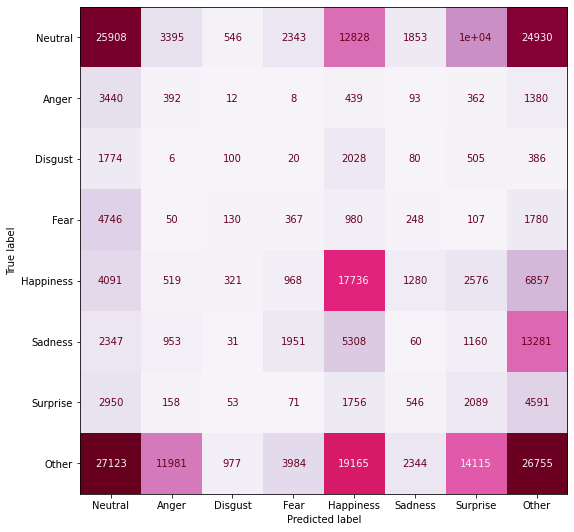

In [43]:
labels=classes
IC = type('IdentityClassifier', (), {"predict": lambda i : i, "_estimator_type": "classifier"})

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

def plt_conf_matrix(y_true,y_pred,labels):
    print(y_pred.shape,y_true.shape, (y_pred==y_true).mean())

    fig, ax = plt.subplots(figsize=(8, 8))
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(ax=ax, cmap='PuRd', colorbar=False)
    plt.tight_layout()
    plt.show()

plt_conf_matrix(np.array(labels_val),np.array(pred_labels_val),labels);

In [44]:
torch.save(model.state_dict(), 'mae_enc_dec.pt')
experiment.log_model("mae_enc_dec.pt", file_or_folder="mae_enc_dec.pt")

{'web': 'https://www.comet.com/api/asset/download?assetId=12fbe98448c544ca9644f4a22b111057&experimentKey=1a8f677fd4fb424a8261b82a5d77e00e',
 'api': 'https://www.comet.com/api/rest/v2/experiment/asset/get-asset?assetId=12fbe98448c544ca9644f4a22b111057&experimentKey=1a8f677fd4fb424a8261b82a5d77e00e',
 'assetId': '12fbe98448c544ca9644f4a22b111057'}

In [45]:
experiment.end()

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/annanet/abaw6/1a8f677fd4fb424a8261b82a5d77e00e
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     avg loss train [40828]     : (1.53829824924469, 2.0800678730010986)
COMET INFO:     avg loss val [192]         : (2.006775158590025, 2.099832892310512)
COMET INFO:     current loss train [40829] : (1.391303300857544, 2.098865032196045)
COMET INFO:     loss [4083]                : (1.422572135925293, 2.07578706741333)
COMET INFO:   Others:
COMET INFO:     Name : MAE finetune enc_dec
COMET INFO:   Parameters:
COMET INFO:     batch     : 256
COMET INFO:     epochs    : 10
COMET INFO:     loss      : categorical_crossentropy
COME

COMET INFO: Still uploading 1 asset(s), remaining 827.34 MB/1.37 GB, Throughput 1022.91 KB/s, ETA ~829s
COMET INFO: Still uploading 1 asset(s), remaining 812.34 MB/1.37 GB, Throughput 1022.91 KB/s, ETA ~814s
COMET INFO: Still uploading 1 asset(s), remaining 802.34 MB/1.37 GB, Throughput 681.94 KB/s, ETA ~1205s
COMET INFO: Still uploading 1 asset(s), remaining 787.34 MB/1.37 GB, Throughput 1022.91 KB/s, ETA ~789s
COMET INFO: Still uploading 1 asset(s), remaining 777.34 MB/1.37 GB, Throughput 681.82 KB/s, ETA ~1168s
COMET INFO: Still uploading 1 asset(s), remaining 767.34 MB/1.37 GB, Throughput 681.79 KB/s, ETA ~1153s
COMET INFO: Still uploading 1 asset(s), remaining 752.34 MB/1.37 GB, Throughput 1022.68 KB/s, ETA ~754s
COMET INFO: Still uploading 1 asset(s), remaining 742.34 MB/1.37 GB, Throughput 681.79 KB/s, ETA ~1115s
COMET INFO: Still uploading 1 asset(s), remaining 722.34 MB/1.37 GB, Throughput 1.33 MB/s, ETA ~543s
COMET INFO: Still uploading 1 asset(s), remaining 712.34 MB/1.37 GB

COMET INFO: Still uploading 1 asset(s), remaining 687.34 MB/1.37 GB, Throughput 0 bytes/s, ETA unknown
COMET INFO: Still uploading 1 asset(s), remaining 687.34 MB/1.37 GB, Throughput 0 bytes/s, ETA unknown
COMET INFO: Still uploading 1 asset(s), remaining 687.34 MB/1.37 GB, Throughput 0 bytes/s, ETA unknown
COMET INFO: Still uploading 1 asset(s), remaining 687.34 MB/1.37 GB, Throughput 0 bytes/s, ETA unknown
COMET INFO: Still uploading 1 asset(s), remaining 682.34 MB/1.37 GB, Throughput 340.97 KB/s, ETA ~2050s
COMET INFO: Still uploading 1 asset(s), remaining 667.34 MB/1.37 GB, Throughput 1022.91 KB/s, ETA ~669s
COMET INFO: Still uploading 1 asset(s), remaining 652.34 MB/1.37 GB, Throughput 1022.91 KB/s, ETA ~654s
COMET INFO: Still uploading 1 asset(s), remaining 637.34 MB/1.37 GB, Throughput 1022.91 KB/s, ETA ~639s
COMET INFO: Still uploading 1 asset(s), remaining 627.34 MB/1.37 GB, Throughput 681.94 KB/s, ETA ~943s
COMET INFO: Still uploading 1 asset(s), remaining 612.34 MB/1.37 GB, 